## Partial slashing simulation
You can jump to __Model 3__ and __Model 3'__ as they are the final models.  
Model 1 and Model 2 are just simple models used for development progess.

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
import math
import numpy as np
import statistics as stats

%matplotlib inline
import matplotlib.pyplot as plt

## Model 1
* Nodes with more than 1500 ETH make pools, and the other nodes joins one of the pools

In [2]:
class PartialSlashingModel(Model):
    def __init__(self, num_users):
        self.num_users = num_users
        self.group = [0]
        self.schedule = RandomActivation(self)
        
        self.prob_join_group = 0.8
                
        for i in range(self.num_users):
            a = User(i, self)
            self.schedule.add(a)
    
    def step(self):
        self.schedule.step()
        
class User(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.group = 0
        
        if random.random() < 0.1:
            self.balance = random.randrange(1500,50000)
        else:
            self.balance = random.randrange(1,1500)
        
    def step(self):
        if self.group == 0:
            if self.balance >= 1500:
                # make a new pool
                self.group = len(model.group)
                self.model.group.append(self.group)

            else:
                #try to find a pool
                if random.random() < self.model.prob_join_group:
                    if len(self.model.group) != 0:
                        self.group = random.randrange(1, len(model.group)+1)

In [3]:
model = PartialSlashingModel(1000)

In [4]:
for i in range(100):
    model.step()

In [5]:
print(model.group)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


(array([ 0., 45., 37., 29., 21., 18., 29., 15., 24., 20., 15., 13., 18.,
        13., 16., 15., 17., 16., 11., 15., 18., 16., 10., 12., 10., 15.,
        13., 12.,  5.,  9.,  9.,  9., 10., 16.,  6., 11., 11.,  6.,  9.,
        13., 10.,  8.,  7.,  9., 10.,  9.,  9.,  5.,  5.,  5.,  8., 13.,
         6.,  6.,  6.,  7.,  8.,  5.,  2.,  7., 12.,  8.,  6.,  3.,  7.,
         8.,  7.,  8.,  6.,  4.,  6.,  5.,  5.,  4.,  9.,  3.,  8.,  4.,
         4.,  5.,  4., 10.,  3.,  3.,  4.,  7.,  4.,  6.,  6.,  2.,  4.,
         3.,  6.,  5.,  3.,  2.,  3.,  3.,  4.,  5.,  4.,  3.,  1.,  3.,
         4.,  2.,  3.,  4.,  1.,  4.,  2.,  2.,  1.,  5.]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  

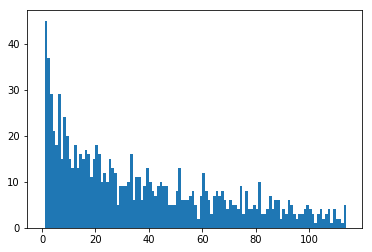

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

user_group = [a.group for a in model.schedule.agents]
plt.hist(user_group, bins=range(0,len(model.group)+1))

## Model 2
* implement interest rates, slashing condition, risk-taking traits
* calculates slashing fraction assuming only one node gets slashed in the period
* constant fault-occurence possibility

In [7]:
class PartialSlashingModel(Model):
    def __init__(self, num_users):
        self.steps = 0
        self.num_users = num_users
        self.group = [0]
        self.group_balance = [0]
        self.schedule = RandomActivation(self)
        self.interests_per_step = 2.378E-6
        self.prob_join_group = 0.8
        self.fault_possibility = 0
                
        for i in range(self.num_users):
            a = User(i, self)
            self.schedule.add(a)
    
    def step(self):
        self.steps += 1
        self.schedule.step()
        
        # to make pools for the initial stage
        if self.fault_possibility == 0 and self.steps >= 100:
            self.fault_possibility = 0.01

            
class User(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.group = 0
    
        if random.random() < 0.1:
            self.balance = random.randrange(1500, 50000)
        else:
            self.balance = random.randrange(1,1500)
            
        # assume the risk-aversioness gets stronger as the balance is high
        self.risk_taking_trait = min(random.uniform(0, 0.1) + 5/self.balance, 1)
        
        
    def step(self):
        if self.group == 0:
            if self.balance >= 1500:
                # make a new pool
                self.group = len(model.group)
                self.model.group.append(self.group)  # nodes with >1500ETH runs own pool.
                self.model.group_balance.append(0)
                self.model.group_balance[self.group] = self.balance

            else:
                # try to join a pool
                if random.random() < self.model.prob_join_group:
                    if len(self.model.group) > 1:
                        system_total_deposits = sum(self.model.group_balance)
                        
                        # assume a node calculates the risk of a group only three times per step.
                        for i in range(3):
                            selected_group = random.randrange(1, len(model.group))
                            possible_slashing_fraction = min(self.model.fault_possibility*3*model.group_balance[selected_group]/system_total_deposits, 1)
                            
                            if self.risk_taking_trait > possible_slashing_fraction:
                                self.group = selected_group
                                self.model.group_balance[self.group] += self.balance
                        
        else:
            self.balance = self.balance*(1+model.interests_per_step)


In [8]:
model = PartialSlashingModel(1000)
for i in range(100):
    model.step()

(array([ 0., 35., 60., 46., 36., 31., 27., 30., 23., 10., 28., 26., 19.,
        27., 23., 19., 21., 25., 11., 19., 15., 15.,  7., 12., 11., 16.,
         9.,  8., 10.,  9.,  8.,  7., 16.,  9., 12., 15.,  9., 14., 14.,
        13.,  6.,  6.,  7.,  8., 14.,  9.,  9.,  8.,  7.,  6.,  7.,  6.,
         7.,  4.,  5.,  4.,  9.,  3.,  4.,  9.,  7.,  4.,  5.,  6.,  5.,
         5.,  8.,  1.,  1.,  4.,  8.,  6.,  4.,  2.,  6.,  2.,  4.,  5.,
         4.,  5.,  1.,  3.,  2.,  4.,  2.,  1.,  2.,  3.,  3.,  4.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90]),
 <a list of 90 Patch objects>)

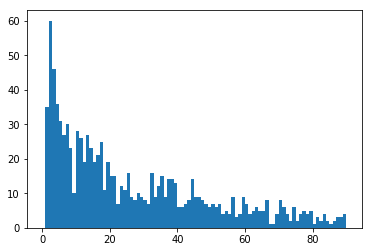

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

user_group = [a.group for a in model.schedule.agents]
plt.hist(user_group, bins=range(0,len(model.group)+1))

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0., 2., 1., 1., 3., 0.,
        0., 2., 0., 3., 0., 0., 1., 1., 1., 1., 2., 1., 4., 1., 0., 2., 0.,
        0., 2., 2., 0., 2., 3., 3., 4., 1., 1., 0., 0., 1., 1., 3., 2., 0.,
        1., 2., 1., 2., 1., 1., 3., 0., 0., 1., 3., 1., 2., 0., 2., 1., 1.,
        0.]),
 array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
         9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
        18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
        27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
        36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
        45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
        54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000,
        63000, 64000, 65000, 66000, 67000, 68000, 69000]),
 <a list of 69 Patch objects>)

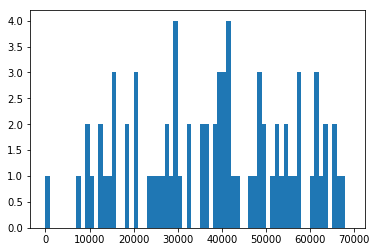

In [10]:
group_balances = [a for a in model.group_balance]
plt.hist(group_balances, bins=np.arange(0,70000,1000))

In [11]:
total_dep = sum(model.group_balance[1:])
avg_dep = sum(model.group_balance[1:])/(len(model.group[1:]))
med_dep = stats.median(model.group_balance[1:])

print("total deposits: {}".format(total_dep))
print("average deposits: {}".format(avg_dep))
print("median deposits: {}".format(med_dep))
print("-------------------------------------")
print("avg/sum: {:.4f}%".format(avg_dep/total_dep*100))
print("med/sum: {:.4f}%".format(med_dep/total_dep*100))
print("-------------------------------------")
print("total num of users: {}".format(len(user_group)))
print("users not in a pool: {}".format(user_group.count(0)))
print("number of pools: {}".format(len(model.group[1:])))

total deposits: 4098675
average deposits: 46052.52808988764
median deposits: 41859
-------------------------------------
avg/sum: 1.1236%
med/sum: 1.0213%
-------------------------------------
total num of users: 1000
users not in a pool: 0
number of pools: 89


## Model 3
* implement leaving the pool when the risk is too high(without withdrawal delay)
* deprecated - people are prone to stay current pool(inertia)
* doesn't leave the pool when the balance of the pool becomes under 1500ETH when the user leaves
* users with > 1500ETH doesn't create pool always
* change initial balance distribution

In [12]:
class PartialSlashingModel(Model):
    def __init__(self, num_users):
        self.steps = 0
        self.num_users = num_users
        self.group = [0]
        self.group_balance = [0]
        self.schedule = RandomActivation(self)
        self.interests_per_step = 2.378E-6
        self.prob_join_group = 0.8
        self.fault_possibility = 0
                
        for i in range(self.num_users):
            a = User(i, self)
            self.schedule.add(a)
    
    def step(self):
        self.steps += 1
        for i in range(len(self.group_balance)):
            self.group_balance[i] = self.group_balance[i]*(1+self.interests_per_step)
            
        self.schedule.step()
        
        # to make pools for the initial stage
        if self.fault_possibility == 0 and self.steps >= 1:
            self.fault_possibility = 0.01

            
class User(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.group = 0
        
        rand_num_for_balance = random.random()
        
        if rand_num_for_balance < 0.001:
            self.balance = random.randrange(3000, 10000)
        elif rand_num_for_balance < 0.01:
            self.balance = random.randrange(1500, 3000)
        else:
            self.balance = random.randrange(1,1500)
            
        # assume the risk-aversioness gets stronger as the balance is high
        self.risk_taking_trait = min(random.uniform(0, 0.1) + 5/self.balance, 1)
        
    def try_to_join_a_pool(self):
        if random.random() < self.model.prob_join_group:
            if len(self.model.group) > 1:
                system_total_deposits = sum(self.model.group_balance)

                # assume a node calculates the risk of a group only three times per step.
                for i in range(3):
                    selected_group = random.randrange(1, len(self.model.group))
                    
                    possible_slashing_fraction = min(self.model.fault_possibility*3*self.model.group_balance[selected_group]/system_total_deposits, 1)

                    if self.risk_taking_trait > possible_slashing_fraction:
                        self.group = selected_group
                        self.model.group_balance[self.group] += self.balance
                        break
        
    def step(self):
        if self.group == 0:
            if self.balance >= 1500:
                if random.random() < 0.1:
                    # make a new pool
                    self.group = len(self.model.group)
                    self.model.group.append(self.group)  # nodes with >1500ETH runs own pool.
                    self.model.group_balance.append(0)
                    self.model.group_balance[self.group] = self.balance
                else:
                    self.try_to_join_a_pool()

            else:
                # try to join a pool
                self.try_to_join_a_pool()
                        
        else:
            self.balance = self.balance*(1+model.interests_per_step)
            system_total_deposits = sum(self.model.group_balance)
            
            possible_slashing_fraction = min(self.model.fault_possibility*3*self.model.group_balance[self.group]/system_total_deposits, 1)
            if self.risk_taking_trait < possible_slashing_fraction:
                if self.model.group_balance[self.group] - self.balance >= 1500:
                    self.model.group_balance[self.group] -= self.balance
                    self.group = 0

In [13]:
model = PartialSlashingModel(30000)
print('initialization finished')
user_groups = []

for i in range(100):
    if i % 10 == 0 and i != 0:
        user_groups.append([a.group for a in model.schedule.agents])
        print('step: {}'.format(i))
    model.step()

# store the final result too
user_groups.append([a.group for a in model.schedule.agents])
print('simulation finished!')

initialization finished
step: 10
step: 20
step: 30
step: 40
step: 50
step: 60
step: 70
step: 80
step: 90
simulation finished!


(array([2661., 2202., 1997., 1676., 1383., 1388., 1390., 1292., 1143.,
        1097., 1037., 1066., 1032.,  933.,  828.,  768.,  767.,  733.,
         667.,  735.,  652.,  613.,  531.,  443.,  420.,  421.,  362.,
         337.,  303.,  346.,  275.,  309.,  163.,   30.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35]),
 <a list of 34 Patch objects>)

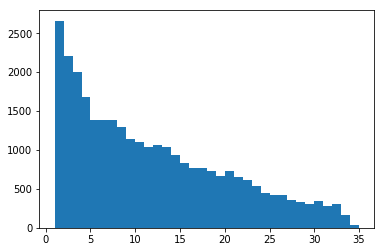

In [14]:
num_plots = len(user_groups)

# fig = plt.figure(figsize=(num_plots*5, num_plots*2))

# for i in range(1,num_plots+1):    
#     plot = fig.add_subplot(2,5,i)
#     plot.hist(user_groups[i-1], bins=range(1,len(model.group)+1))
    
plt.hist(user_groups[9], bins=range(1,len(model.group)+1))

(array([2., 3., 6., 2., 4., 4., 3., 3., 1., 3., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
        0.18 , 0.185, 0.19 , 0.195]),
 <a list of 39 Patch objects>)

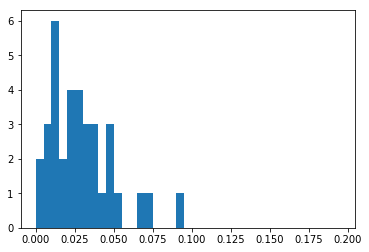

In [15]:
total_dep = sum(model.group_balance[1:])
group_balances = [a/total_dep for a in model.group_balance]
plt.hist(group_balances, bins=np.arange(0,0.2,0.005))
# plt.hist(group_balances, bins='auto')

In [16]:
total_dep = sum(model.group_balance[1:])
avg_dep = sum(model.group_balance[1:])/(len(model.group[1:]))
med_dep = stats.median(model.group_balance[1:])
largest_dep = max(model.group_balance)

user_balances = np.array([a.balance for a in model.schedule.agents])
user_group = [a.group for a in model.schedule.agents]

print("total deposits: {}".format(total_dep))
print("average deposits: {}".format(avg_dep))
print("median deposits: {}".format(med_dep))
print("-------------------------------------")
print("avg/sum: {:.4f}%".format(avg_dep/total_dep*100))
print("med/sum: {:.4f}%".format(med_dep/total_dep*100))
print("-------------------------------------")
print("largest deposit of a pool: {}".format(largest_dep))
print("share of the largest pool: {:.4f}%".format(largest_dep/total_dep*100))
print("-------------------------------------")
print("total num of users: {}".format(len(user_group)))
print("users not in a pool: {}".format(user_group.count(0)))
print("number of pools: {}".format(len(model.group[1:])))
print("users > 1500ETH: {}".format(len(user_balances[user_balances>1500])))

total deposits: 23201279.235828362
average deposits: 682390.5657596578
median deposits: 590884.1604157616
-------------------------------------
avg/sum: 2.9412%
med/sum: 2.5468%
-------------------------------------
largest deposit of a pool: 2089136.3546236895
share of the largest pool: 9.0044%
-------------------------------------
total num of users: 30000
users not in a pool: 0
number of pools: 34
users > 1500ETH: 288


In [17]:
user_balances = np.array([a.balance for a in model.schedule.agents])
print('users > 1500')
print(sorted(user_balances[user_balances>1500]))
print('group balances')
print(sorted([a for a in model.group_balance]))

users > 1500
[1501.3534096003646, 1506.3545868475344, 1511.3557640947038, 1514.356470443008, 1519.3576476901762, 1524.3588249373465, 1526.359295836213, 1532.3607085328185, 1532.3607085328185, 1532.3607085328185, 1538.362121229421, 1549.364711173196, 1553.36565297093, 1559.3670656675338, 1559.3670656675338, 1598.376248195458, 1605.377896341498, 1619.3811926335713, 1623.382134431308, 1631.3801386048103, 1632.3764898843963, 1633.3844889256466, 1639.385901622251, 1645.3873143188557, 1656.389904262628, 1666.3922587569673, 1666.3922587569673, 1672.393671453571, 1697.3995576894188, 1701.3964535663886, 1704.393099732236, 1706.3976189207885, 1706.4016767343264, 1709.402383082627, 1721.4052084758355, 1723.4056793747031, 1723.4056793747031, 1723.4056793747031, 1727.4066211724391, 1730.4073275207413, 1733.408033869042, 1744.410623812815, 1756.413449206022, 1769.4123023862103, 1770.4167454980998, 1771.4169809475322, 1773.4174518463988, 1775.4179227452676, 1777.4183936441364, 1790.4214544867773, 181

In [18]:
# do the simulation multiple times to get general result
avg_sum_list = []
med_sum_list = []
largest_share_list = []

for j in range(10):
    _model = PartialSlashingModel(30000)
    for i in range(100):
        _model.step()
    print('simulation {} finished!'.format(j))
    
    total_dep = sum(_model.group_balance[1:])
    avg_dep = sum(_model.group_balance[1:])/(len(_model.group[1:]))
    med_dep = stats.median(_model.group_balance[1:])
    largest_dep = max(_model.group_balance)
    
    avg_sum = avg_dep/total_dep*100
    med_sum = med_dep/total_dep*100
    largest_share = largest_dep/total_dep*100
    
    avg_sum_list.append(avg_sum)
    med_sum_list.append(med_sum)
    largest_share_list.append(largest_share)

simulation 0 finished!
simulation 1 finished!
simulation 2 finished!
simulation 3 finished!
simulation 4 finished!
simulation 5 finished!
simulation 6 finished!
simulation 7 finished!
simulation 8 finished!
simulation 9 finished!


In [19]:
print("avg_sum_list")
print(avg_sum_list)

print("med_sum_list")
print(med_sum_list)

print("largest_share_list")
print(largest_share_list)

avg_sum_list
[2.4390243902439024, 2.9411764705882355, 2.083333333333333, 3.571428571428571, 3.571428571428571, 2.631578947368421, 3.125, 3.0303030303030303, 2.857142857142857, 2.7027027027027026]
med_sum_list
[2.3074150780443583, 1.6385453735397477, 1.6647325319184132, 1.713248302303597, 2.8809741379497806, 1.3507509238604936, 2.6301331664863787, 1.8725335468494069, 2.01258549458041, 2.1769078820725594]
largest_share_list
[8.490009972863552, 12.536355975084343, 11.48339072411435, 21.33712254316676, 12.24784039084608, 12.545201383311225, 14.041289706622539, 15.366054465931786, 8.348649775211129, 12.218666389464682]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 0., 0., 0., 0., 1., 0., 2., 2., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5]),
 <a list of 39 Patch objects>)

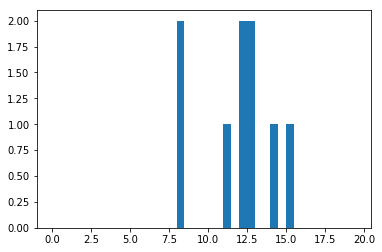

In [20]:
plt.hist(largest_share_list, bins=np.arange(0,20,0.5))

In [21]:
print("avg of avg: {}".format(sum(avg_sum_list) / len(avg_sum_list)))
print("avg of med: {}".format(sum(med_sum_list) / len(med_sum_list)))
print("avg of largest share: {}".format(sum(largest_share_list) / len(largest_share_list)))

avg of avg: 2.8953118874539623
avg of med: 2.0247826437605143
avg of largest share: 12.861458132661644


## Model 3'
* users choose optimal pool (join the pool with the lowest deposit share)

In [22]:
class PartialSlashingModelOptimal(Model):
    def __init__(self, num_users):
        self.steps = 0
        self.num_users = num_users
        self.group = [0]
        self.group_balance = [0]
        self.schedule = RandomActivation(self)
        self.interests_per_step = 2.378E-6
        self.prob_join_group = 0.8
        self.fault_possibility = 0
                
        for i in range(self.num_users):
            a = User(i, self)
            self.schedule.add(a)
    
    def step(self):
        self.steps += 1
        for i in range(len(self.group_balance)):
            self.group_balance[i] = self.group_balance[i]*(1+self.interests_per_step)
        
        self.schedule.step()
        
        # to make pools for the initial stage
        if self.fault_possibility == 0 and self.steps >= 100:
            self.fault_possibility = 0.01

            
class User(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.group = 0
        
        rand_num_for_balance = random.random()
        
        if rand_num_for_balance < 0.001:
            self.balance = random.randrange(3000, 10000)
        elif rand_num_for_balance < 0.01:
            self.balance = random.randrange(1500, 3000)
        else:
            self.balance = random.randrange(1,1500)
            
        # assume the risk-aversioness gets stronger as the balance is high
        self.risk_taking_trait = min(random.uniform(0, 0.1) + 5/self.balance, 1)
        
    def try_to_join_a_pool(self):
        if random.random() < self.model.prob_join_group:
            if len(self.model.group) > 1:
                system_total_deposits = sum(self.model.group_balance)
                
                if len(self.model.group_balance) > 1:
                    lowest_share_group = np.argmin(np.array(self.model.group_balance[1:])) + 1 # to avoid group 0
                    
                    possible_slashing_fraction = min(self.model.fault_possibility*3*self.model.group_balance[lowest_share_group]/system_total_deposits, 1)

                    if self.risk_taking_trait > possible_slashing_fraction:
                        self.group = lowest_share_group
                        self.model.group_balance[self.group] += self.balance
        
    def step(self):
        if self.group == 0:
            if self.balance >= 1500:
                if random.random() < 0.1:
                    # make a new pool
                    self.group = len(self.model.group)
                    self.model.group.append(self.group)  # nodes with >1500ETH runs own pool.
                    self.model.group_balance.append(0)
                    self.model.group_balance[self.group] = self.balance
                else:
                    self.try_to_join_a_pool()

            else:
                # try to join a pool
                self.try_to_join_a_pool()
                        
        else:
            self.balance = self.balance*(1+model.interests_per_step)
            system_total_deposits = sum(self.model.group_balance)
            
            possible_slashing_fraction = min(self.model.fault_possibility*3*self.model.group_balance[self.group]/system_total_deposits, 1)
            if self.risk_taking_trait < possible_slashing_fraction:
                if self.model.group_balance[self.group] - self.balance >= 1500:
                    self.model.group_balance[self.group] -= self.balance
                    self.group = 0

In [23]:
model_opt = PartialSlashingModelOptimal(30000)
print('initialization finished')
user_groups_opt = []

for i in range(100):
    if i % 10 == 0 and i != 0:
        user_groups_opt.append([a.group for a in model_opt.schedule.agents])
        print('step: {}'.format(i))
    model_opt.step()

# store the final result too
user_groups_opt.append([a.group for a in model_opt.schedule.agents])
print('simulation finished!')


initialization finished
step: 10
step: 20
step: 30
step: 40
step: 50
step: 60
step: 70
step: 80
step: 90
simulation finished!


(array([1611., 1599., 1598., 1531., 1572., 1576., 1571., 1563.,  908.,
         912.,  951.,  916.,  866.,  846.,  857.,  820.,  872.,  844.,
         861.,  870.,  848.,  867.,  866.,  850.,  874.,  874.,  842.,
         835.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 28 Patch objects>)

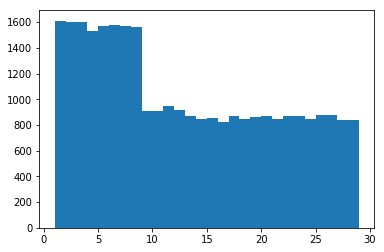

In [24]:
num_plots = len(user_groups_opt)

# fig_opt = plt.figure(figsize=(num_plots*5, num_plots*2))

# for i in range(1,num_plots+1):    
#     plot = fig_opt.add_subplot(2,5,i)
#     plot.hist(user_groups_opt[i-1], bins=range(1,len(model_opt.group)+1))
    
plt.hist(user_groups_opt[9], bins=range(1,len(model_opt.group)+1))

(array([ 0.,  0.,  0.,  0.,  0., 16.,  4.,  0.,  0.,  0.,  8.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
        0.18 , 0.185, 0.19 , 0.195]),
 <a list of 39 Patch objects>)

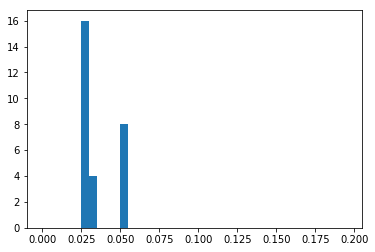

In [25]:
total_dep = sum(model_opt.group_balance[1:])
group_balances = [a/total_dep for a in model_opt.group_balance[1:]]
plt.hist(group_balances, bins=np.arange(0,0.2,0.005))
# plt.hist(group_balances, bins='auto')

In [26]:
total_dep = sum(model_opt.group_balance[1:])
avg_dep = sum(model_opt.group_balance[1:])/(len(model_opt.group[1:]))
med_dep = stats.median(model_opt.group_balance[1:])
largest_dep = max(model_opt.group_balance)

user_group = [a.group for a in model_opt.schedule.agents]
user_balances = np.array([a.balance for a in model_opt.schedule.agents])

print("total deposits: {}".format(total_dep))
print("average deposits: {}".format(avg_dep))
print("median deposits: {}".format(med_dep))
print("-------------------------------------")
print("avg/sum: {:.4f}%".format(avg_dep/total_dep*100))
print("med/sum: {:.4f}%".format(med_dep/total_dep*100))
print("-------------------------------------")
print("largest deposit of a pool: {}".format(largest_dep))
print("share of the largest pool: {:.4f}%".format(largest_dep/total_dep*100))
print("-------------------------------------")
print("total num of users: {}".format(len(user_group)))
print("users not in a pool: {}".format(user_group.count(0)))
print("number of pools: {}".format(len(model_opt.group[1:])))
print("users > 1500ETH: {}".format(len(user_balances[user_balances>1500])))

total deposits: 23012375.970052045
average deposits: 821870.5703590016
median deposits: 655453.7205964301
-------------------------------------
avg/sum: 3.5714%
med/sum: 2.8483%
-------------------------------------
largest deposit of a pool: 1212647.4499466484
share of the largest pool: 5.2695%
-------------------------------------
total num of users: 30000
users not in a pool: 0
number of pools: 28
users > 1500ETH: 281


In [27]:
user_balances = np.array([a.balance for a in model_opt.schedule.agents])
print('user balances >1500')
print(sorted(user_balances[user_balances>1500]))
print('group balances')
print(sorted([a for a in model_opt.group_balance]))

user balances >1500
[1511.3557640947038, 1525.35906038678, 1529.3563653750796, 1529.3600021845166, 1534.3611794316853, 1535.357763800357, 1538.362121229421, 1547.3642402743274, 1550.3649466226288, 1555.366123869798, 1560.367301116968, 1560.367301116968, 1564.3682429147034, 1587.3736582516856, 1591.3746000494207, 1602.3771899931944, 1602.3771899931944, 1605.377896341498, 1609.3788381392328, 1629.3835471279106, 1632.3842534762132, 1634.3847243750813, 1640.386137071684, 1650.3845669515233, 1657.3822571926733, 1659.3906106109293, 1660.3908460603645, 1679.3953195996098, 1696.3993222399868, 1699.4000285882883, 1701.4004994871552, 1703.4009703860238, 1705.4014412848926, 1717.3920147743302, 1730.4073275207413, 1755.4132137565894, 1759.414155554325, 1771.4169809475322, 1777.4183936441364, 1786.4205126890427, 1807.4254571271551, 1808.421392150519, 1811.4263989248918, 1828.4304015652679, 1835.432049711307, 1837.4325206101732, 1845.4344042056457, 1848.4351105539472, 1855.4367586999842, 1862.438406

In [28]:
# do the simulation multiple times to get general result
avg_sum_list_opt = []
med_sum_list_opt = []
largest_share_list_opt = []

for j in range(10):
    _model = PartialSlashingModelOptimal(30000)
    for i in range(100):
        _model.step()
    print('simulation {} finished!'.format(j))
    
    total_dep = sum(_model.group_balance[1:])
    avg_dep = sum(_model.group_balance[1:])/(len(_model.group[1:]))
    med_dep = stats.median(_model.group_balance[1:])
    largest_dep = max(_model.group_balance)
    
    avg_sum = avg_dep/total_dep*100
    med_sum = med_dep/total_dep*100
    largest_share = largest_dep/total_dep*100
    
    avg_sum_list_opt.append(avg_sum)
    med_sum_list_opt.append(med_sum)
    largest_share_list_opt.append(largest_share)

simulation 0 finished!
simulation 1 finished!
simulation 2 finished!
simulation 3 finished!
simulation 4 finished!
simulation 5 finished!
simulation 6 finished!
simulation 7 finished!
simulation 8 finished!
simulation 9 finished!


In [29]:
print("avg_sum_list_opt")
print(avg_sum_list_opt)

print("med_sum_list_opt")
print(med_sum_list_opt)

print("largest_share_listv")
print(largest_share_list_opt)

avg_sum_list_opt
[2.1739130434782608, 2.7027027027027026, 2.857142857142857, 3.7037037037037033, 3.3333333333333335, 2.631578947368421, 2.564102564102564, 2.272727272727273, 2.3255813953488373, 2.7027027027027026]
med_sum_list_opt
[2.3485188828361516, 2.8516936218447966, 3.0505689714017232, 3.1020418249856694, 2.8411214469001247, 2.6303094591207246, 2.777349381210662, 2.290743413672762, 2.165991718225454, 2.730051114929811]
largest_share_listv
[2.4038207483196494, 3.913289547653381, 3.055088684892145, 6.721602653128109, 5.7639146592515775, 2.665264096597721, 2.7814211853359407, 2.293892586612679, 6.311166387824652, 2.733600183866115]


(array([0., 0., 0., 0., 2., 3., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5]),
 <a list of 39 Patch objects>)

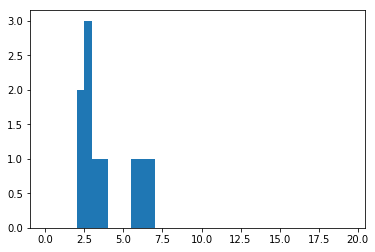

In [30]:
plt.hist(largest_share_list_opt, bins=np.arange(0,20,0.5))

In [31]:
print("avg of avg: {:.4f}%".format(sum(avg_sum_list_opt) / len(avg_sum_list_opt)))
print("avg of med: {:.4f}%".format(sum(med_sum_list_opt) / len(med_sum_list_opt)))
print("avg of largest share: {:.4f}%".format(sum(largest_share_list_opt) / len(largest_share_list_opt)))

avg of avg: 2.7267%
avg of med: 2.6788%
avg of largest share: 3.8643%
